In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def imshow(image):
    nchannel = len(image.shape)
    
    if nchannel == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.show() 

# Traffic Sign Classification

In [2]:
image_path = "/home/ngin/autonomous_car/data/traffic_sign_images/1.jpg"
image = cv2.imread(image_path)


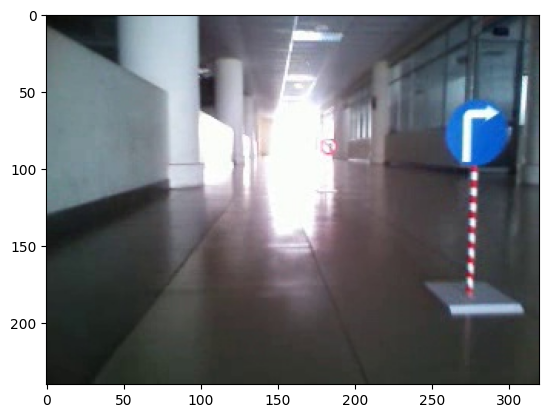

In [13]:
imshow(image)

In [19]:
def filter_signs_by_color(image):
    """Lọc biển báo theo màu sắc
    """

    # Chuyển sang hệ màu HSV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Lọc màu đỏ
    lower1, upper1 = np.array([0, 70, 50]), np.array([10, 255, 255])
    lower2, upper2 = np.array([170, 70, 50]), np.array([180, 255, 255])
    mask_1 = cv2.inRange(image, lower1, upper1)
    mask_2 = cv2.inRange(image, lower2, upper2)
    mask_r = cv2.bitwise_or(mask_1, mask_2)

    # Lọc màu xanh dương
    lower3, upper3 = np.array([100, 150, 0]), np.array([140, 255, 255])
    mask_b = cv2.inRange(image, lower3, upper3)

    # Kết hợp các kết quả
    mask_final = cv2.bitwise_or(mask_r, mask_b)
    
    return mask_final

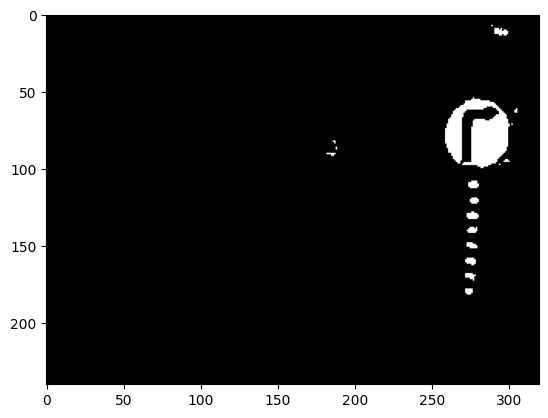

In [20]:
filtered_image = filter_signs_by_color(image)

imshow(filtered_image)

In [25]:
def get_boxes_from_mask(mask):
    """Tìm kiếm hộp bao biển báo
    """
    bboxes = []

    nccomps = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    numLabels, labels, stats, centroids = nccomps
    im_height, im_width = mask.shape[:2]
    for i in range(numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        # Lọc các vật quá nhỏ, có thể là nhiễu
        if w < 20 or h < 20:
            continue
        # Lọc các vật quá lớn
        if w > 0.8 * im_width or h > 0.8 * im_height:
            continue
        # Loại bỏ các vật có tỷ lệ dài / rộng quá khác biệt
        if w / h > 2.0 or h / w > 2.0:
            continue
        bboxes.append([x, y, w, h])
    return bboxes

In [30]:
def detect_traffic_signs(img, model, draw=None):
    """Phát hiện biển báo
    """

    # Các lớp biển báo
    classes = ['unknown', 'left', 'no_left', 'right',
               'no_right', 'straight', 'stop']

    # Phát hiện biển báo theo màu sắc
    mask = filter_signs_by_color(img)
    bboxes = get_boxes_from_mask(mask)

    # Tiền xử lý
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img / 255.0

    # Phân loại biển báo dùng CNN
    signs = []
    for bbox in bboxes:
        # Cắt vùng cần phân loại
        x, y, w, h = bbox
        sub_image = img[y:y+h, x:x+w]

        if sub_image.shape[0] < 20 or sub_image.shape[1] < 20:
            continue

        # Tiền xử lý
        sub_image = cv2.resize(sub_image, (32, 32))
        sub_image = np.expand_dims(sub_image, axis=0)

        # Sử dụng CNN để phân loại biển báo
        model.setInput(sub_image)
        preds = model.forward()
        preds = preds[0]
        cls = preds.argmax()
        score = preds[cls]

        # Loại bỏ các vật không phải biển báo - thuộc lớp unknown
        if cls == 0:
            continue

        # Loại bỏ các vật có độ tin cậy thấp
        if score < 0.5:
            continue

        signs.append([classes[cls], x, y, w, h])

        # Vẽ các kết quả
        if draw is not None:
            text = classes[cls] + ' ' + str(round(score, 2))
            cv2.rectangle(draw, (x, y), (x+w, y+h), (0, 255, 255), 4)
            cv2.putText(draw, text, (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    return signs

In [33]:
model_path = "/home/ngin/autonomous_car/models/traffic_sign_classifier_lenet_v2.onnx"
model = cv2.dnn.readNetFromONNX(model_path)

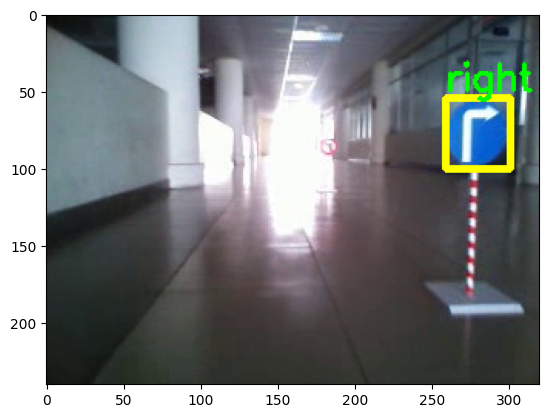

In [34]:
draw = image.copy()
sign = detect_traffic_signs(image, model, draw)

imshow(draw)